## Contest 1 | Linear Regreesion

Выполнил: Волков Алексей
Итоговый MSE: 21.09 (минимальный 18.602)

In [4168]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt

Будем придерживаться пайплайна с семинара

### Этап 1 | Подготовка данных

In [4169]:
DATA_PATH = "data/train.csv"
df = pd.read_csv(DATA_PATH)

Для начала удалим дубликаты в данных. Для этого используем метод *drop_duplicates()*.

In [4170]:
df.drop_duplicates(inplace=True)

Также удалим  полностью пустые строки.

In [4171]:
df.dropna(how='all', inplace=True)

Теперь поработаем с пропусками в данных. Для более качественной оценки ситуации с пропусками попробуем вывести матрицу пропущенных значений. Для этого можно использовать библиотеку **missingno**.

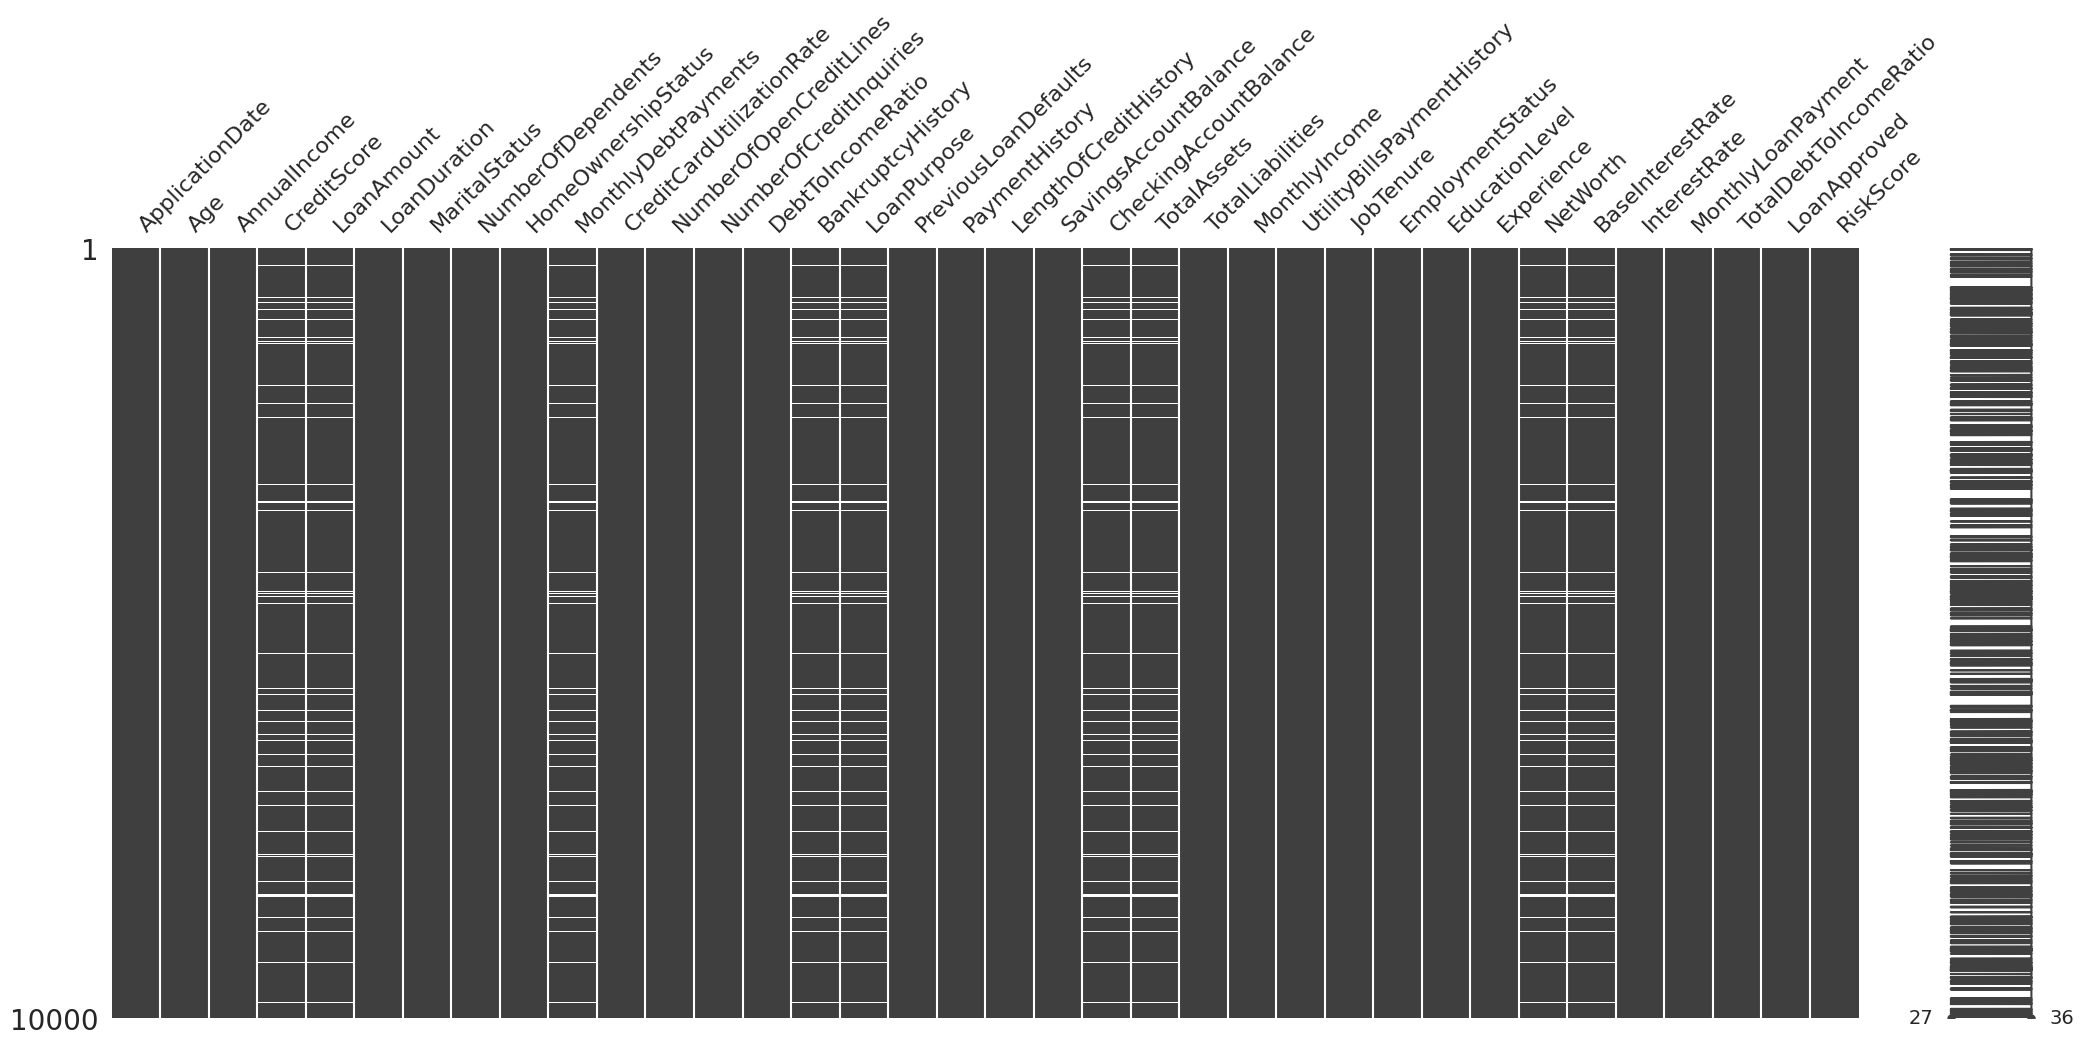

In [4172]:
import missingno as msno

sns.set()
msno.matrix(df)
plt.show()

Видим пропуски в нескольких столбцах в определенных строках. Попробуем их заполнить с помощью модели K-соседей, чтобы не потерять строки, которые могут помочь в улучшении качества предсказаний. Перед заполнением пропусков в данных, займемся их подготовкой к заполнению. Для необходимо будет применить OneHotEncoding для категориальных признаков, но перед этим мы должны проверить в каких категориальных признаках встречаются пропуски.

In [4173]:
for column in np.array(df.select_dtypes(include=['object']).columns):
    if df[column].count() != 10000:
        print(column)

LoanPurpose


Видим что есть только один столбец с категориальными данными, у которого есть пропуски. Попробуем убрать эти пропуски с помощью заполнения модой. Сделаем это с помощью класса **SimpleImputer**.

In [4174]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')

df['LoanPurpose'] = imp.fit_transform(df[['LoanPurpose']]).ravel()

Убедимся, что теперь в этом столбце нет пропусков.

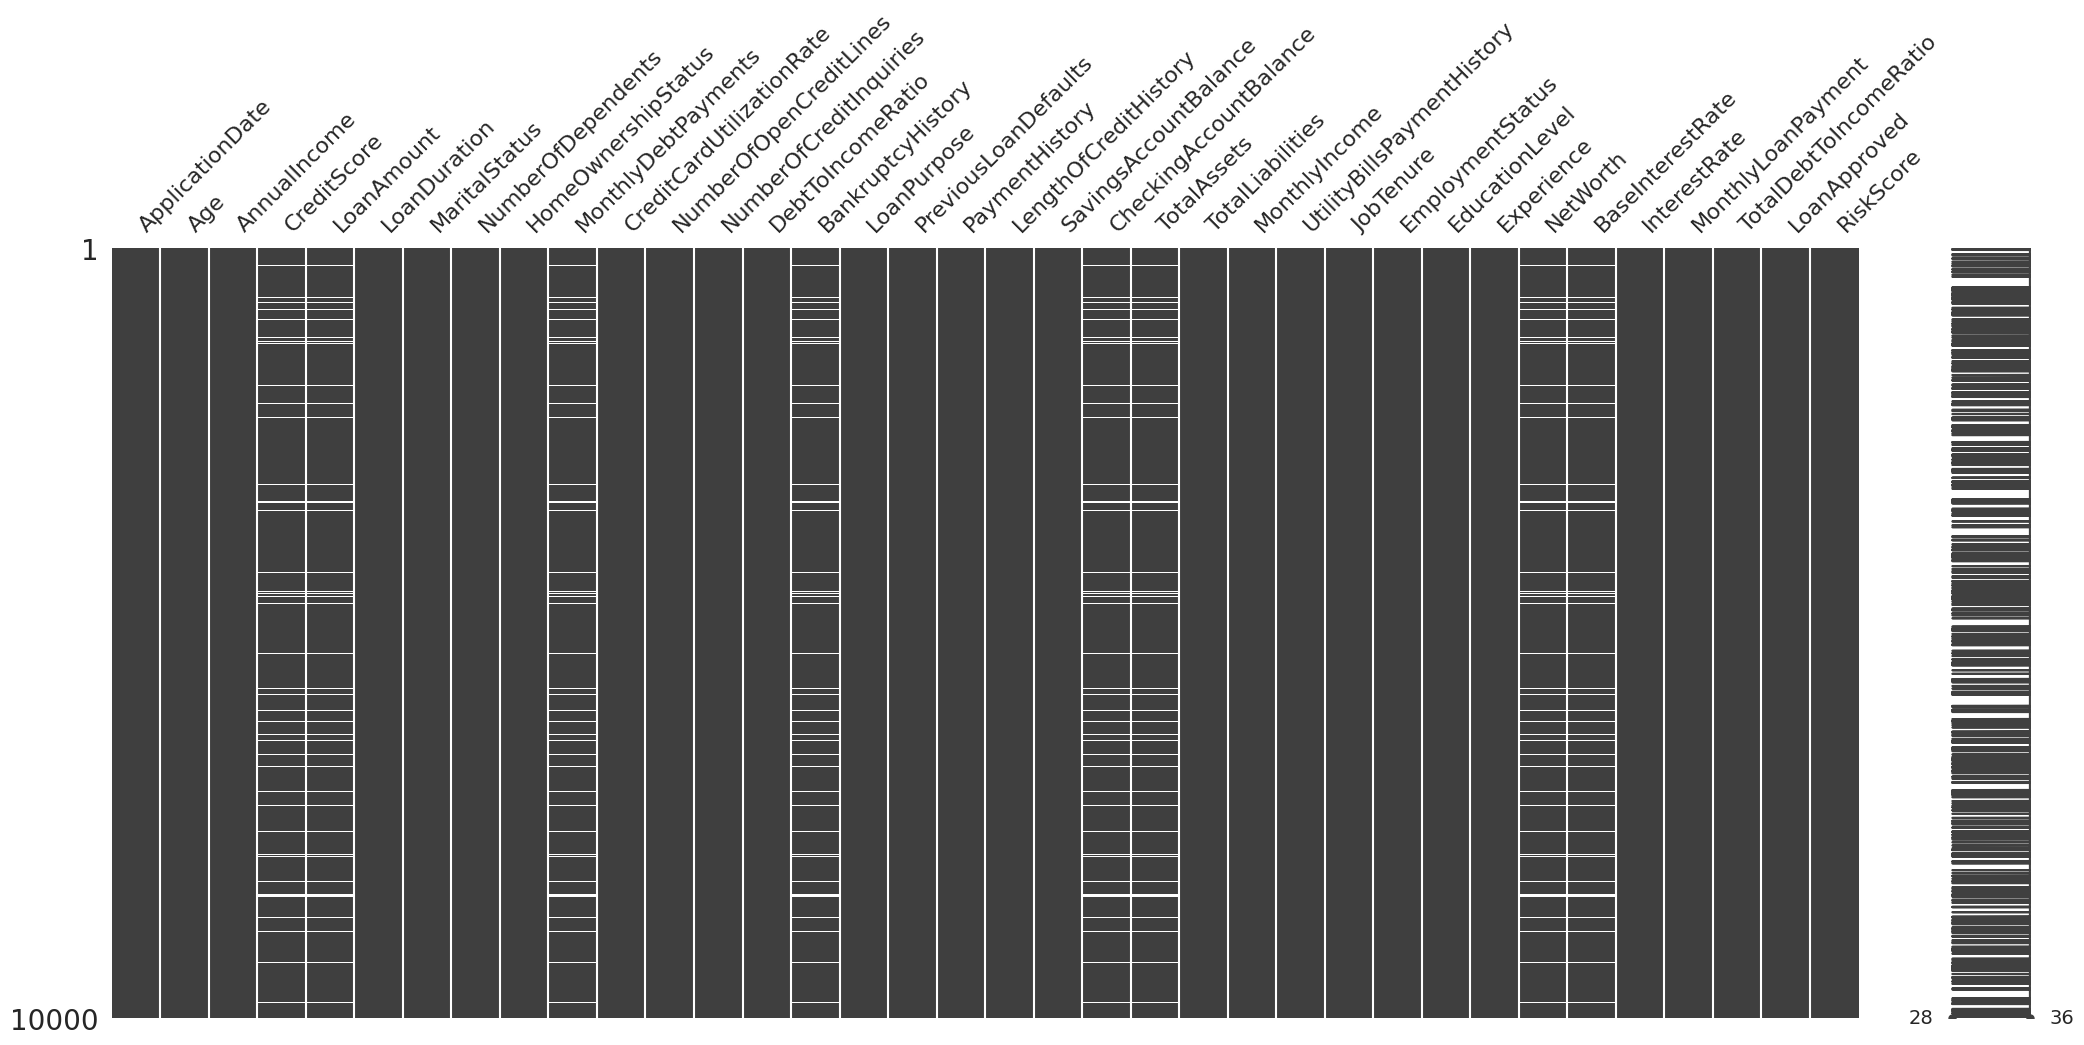

In [4175]:
msno.matrix(df)
plt.show()

Видим, что в столбце LoanPurpose пропусков нет, и теперь можно перейти к кодированию и масштабированию. Будем использовать MinMax масштабирование, чтобы привести все необходимсые признаки к диапазону значений от 0 до 1.

In [4176]:
from sklearn.preprocessing import MinMaxScaler

knn = df.drop(['ApplicationDate', 'RiskScore'], axis=1)

knn = pd.get_dummies(knn, columns=np.array(knn.select_dtypes(include=['object']).columns)) # кодирование категориальных данных

scaler = MinMaxScaler()

knn = pd.DataFrame(scaler.fit_transform(knn), columns=knn.columns) # масштабируем

Теперь заполним пропуски. Возьмем для заполнения 10 ближайших соседей.

In [4177]:
from sklearn.impute import KNNImputer

# если просто удалить все значения в которых встречаются пропуски, то модель будет работать лучше
# скорее всего это работает так как данных с пропусками не так много, но все равно применим KNN, чтобы знать такой метод заполнения пропусков в будущем

knn_imputer = KNNImputer(n_neighbors = 10, weights = 'uniform')

knn = pd.DataFrame(knn_imputer.fit_transform(knn), columns=knn.columns) # заполняем пропуски

Вернем данные в исходный датасет.

In [4178]:
df = df.drop(np.array(df.columns)[1:-1], axis=1).join(knn)

Теперь посмотрим остались ли у нас пропуски.

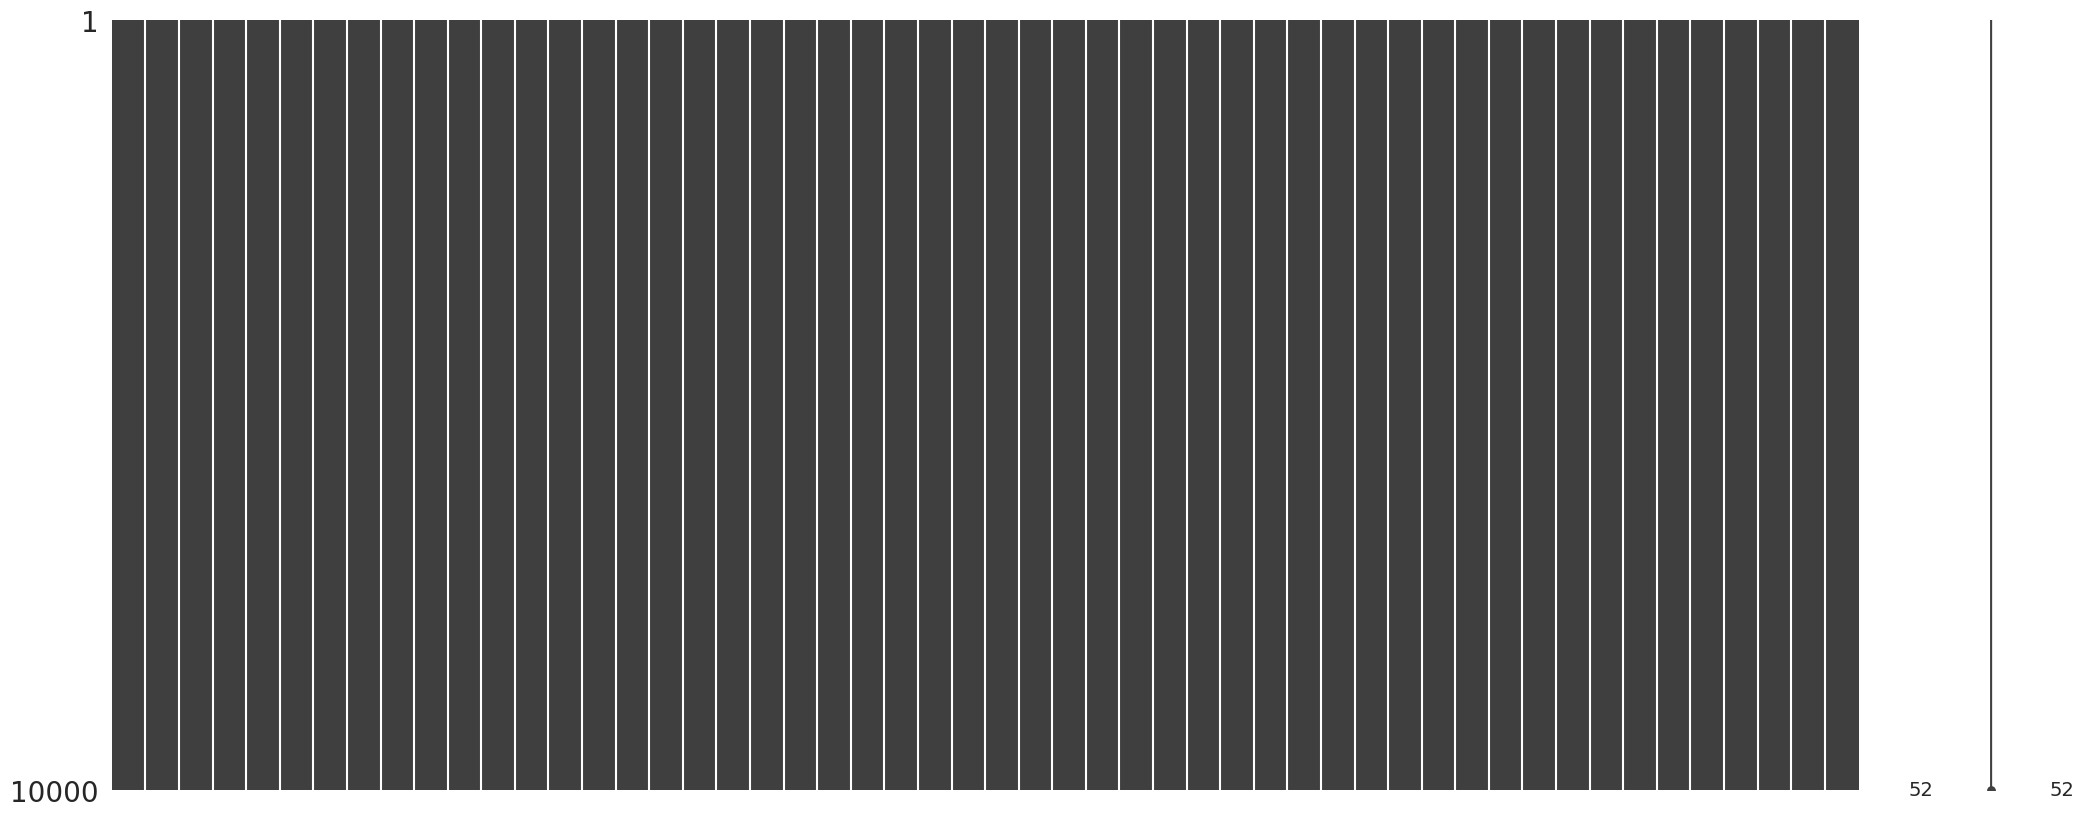

In [4179]:
msno.matrix(df)
plt.show()

Теперь у нас есть датасет с закодированными, масштабированными данными без пропусков. Можем перейти к работе с выбросами данных. Посмотрим на значения в столбце таргета.

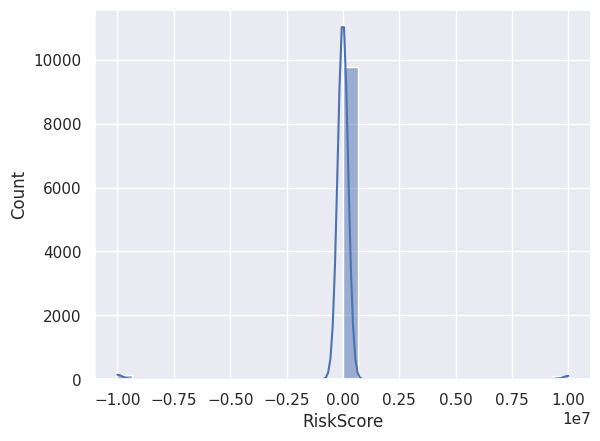

In [4180]:
sns.histplot(df['RiskScore'], bins=30, kde=True)
plt.show()

Видим, что у нас странное распределение данных в этом столбце, поэтому попробуем обработать выбросы в нем с помощью метода межквартильных расстояний.

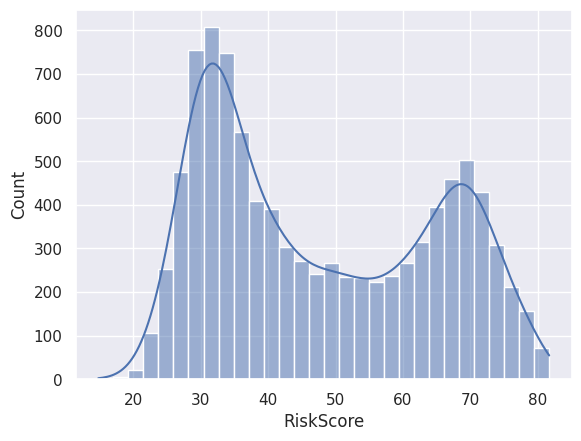

In [4181]:
Q1 = df['RiskScore'].quantile(0.25) # Если тут взять quantile(0.2), то модель работает лучше
Q3 = df['RiskScore'].quantile(0.75) # Если тут взять quantile(0.8), то модель работает лучше
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR # Если тут взять 2 межквартильных размаха, то модель работает лучше
upper_bound = Q1 + 1.5 * IQR # Если тут взять 2 межквартильных размаха, то модель работает лучше


df['RiskScore'] = df['RiskScore'].where((df['RiskScore'] >= lower_bound) & (df['RiskScore'] <= upper_bound), np.nan)
df.dropna(inplace=True)

sns.histplot(df['RiskScore'], bins=30, kde=True)
plt.show()

Теперь видим более-менее нормальное распределение данных в данном столбце. Далее посмотрим на распределения нескольких самых сильновлияющих на таргет признаков. Узнать коэффицент влияния признака на таргет можно с помощью модели **RandomForestRegressor**.

In [4182]:
from sklearn.ensemble import RandomForestRegressor

X_coef = df.drop(['ApplicationDate', 'RiskScore'], axis=1)
y_coef = df['RiskScore'];

results = []
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_coef, y_coef)
for i in range(len(rf.feature_importances_)):
    results.append([X_coef.columns[i], rf.feature_importances_[i]])

results.sort(key=lambda x: x[1])
print(results[::-1])

[['LoanApproved', np.float64(0.7674532631981477)], ['CreditScore', np.float64(0.12488913952111531)], ['DebtToIncomeRatio', np.float64(0.018765380205798574)], ['BankruptcyHistory', np.float64(0.016073256520275216)], ['NetWorth', np.float64(0.013833102431211698)], ['MonthlyIncome', np.float64(0.010158008462336401)], ['AnnualIncome', np.float64(0.008216981756389059)], ['CreditCardUtilizationRate', np.float64(0.004509822327152804)], ['LengthOfCreditHistory', np.float64(0.004377780359239844)], ['InterestRate', np.float64(0.0040915425317079885)], ['TotalAssets', np.float64(0.00374936339558381)], ['TotalLiabilities', np.float64(0.0016349763243830137)], ['CheckingAccountBalance', np.float64(0.0016080858833624828)], ['SavingsAccountBalance', np.float64(0.001577139110679737)], ['UtilityBillsPaymentHistory', np.float64(0.0015710483071369838)], ['TotalDebtToIncomeRatio', np.float64(0.0015162077138438344)], ['MonthlyDebtPayments', np.float64(0.0014081875500626035)], ['EmploymentStatus_Employed', np

Видим, что сильнее всего на таргет влияют признаки LoanApproved, CreditScore, BankruotcyHistory. Посмотрим на их распределения.

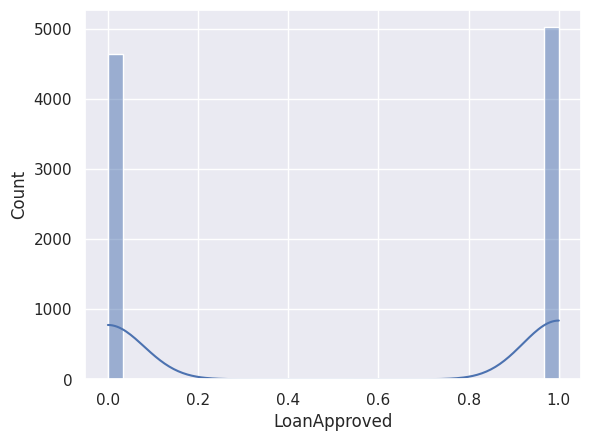

In [4183]:
sns.histplot(df['LoanApproved'], bins=30, kde=True)
plt.show()

Видим, что это категориальный признак, значения в нем примерно сбалансированы, поэтому можно ничего с ним не делать. Далее посмотрим на столбец CreditScore.

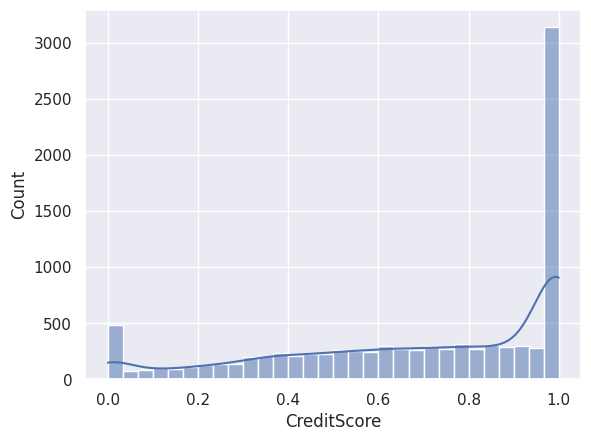

In [4184]:
sns.histplot(df['CreditScore'], bins=30, kde=True)
plt.show()

Видим потенциальные выбросы, которые могут повлиять на итоговую модель. Попробуем выяснить являются ли эти значения выбросами с точки зрения статистического метода. Опять применим метод межквартильных расстояний.

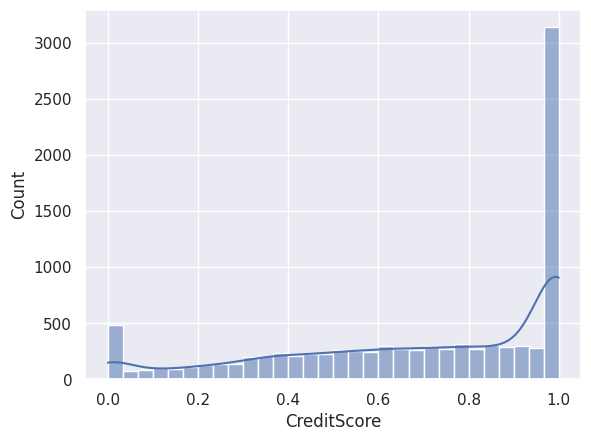

In [4185]:
Q1 = df['CreditScore'].quantile(0.25) 
Q3 = df['CreditScore'].quantile(0.75) 
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q1 + 1.5 * IQR


df['CreditScore'] = df['CreditScore'].where((df['CreditScore'] >= lower_bound) & (df['CreditScore'] <= upper_bound), np.nan)
df.dropna(inplace=True)

sns.histplot(df['CreditScore'], bins=30, kde=True)
plt.show()

Видим, что после применения метода межквартильных расстояний ничего не изменилось. Значит с точки зрения статистического метода эти значения выбросами не являются. Перейдем к следующему признаку.

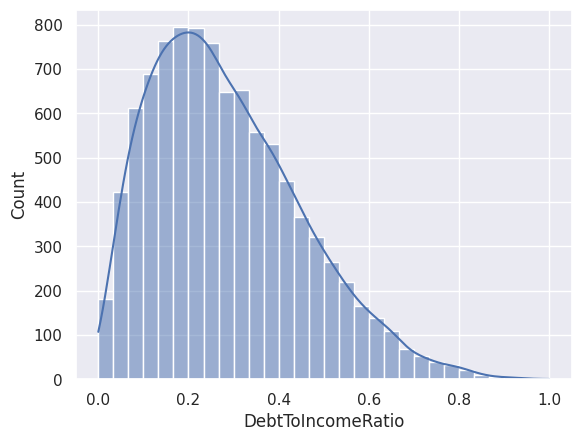

In [4186]:
sns.histplot(df['DebtToIncomeRatio'], bins=30, kde=True)
plt.show()

Видим вполне нормальное распределение значений в столбце. Можем перейти к следующему признаку.

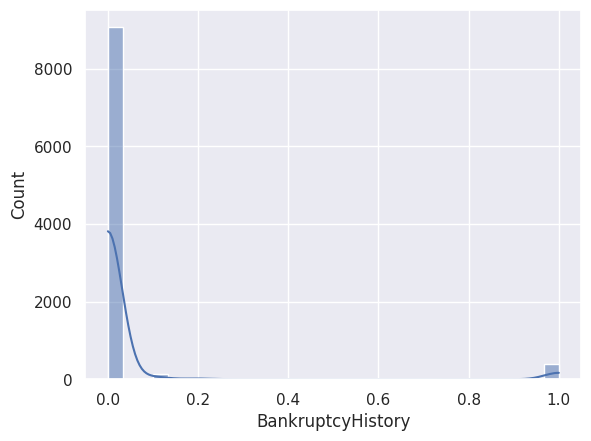

In [4187]:
sns.histplot(df['BankruptcyHistory'], bins=30, kde=True)
plt.show()

Опять-же таки видим категориальный признак, но его распределение не сбалансировано. В данном случае ничего сделать не получится, так как количество строк со значением 0 слишком велико, и полностью избавившись от строк с таким значением мы только ухудшим нашу модель, поэтому оставим все как есть. Посмотрим на следующий признак.

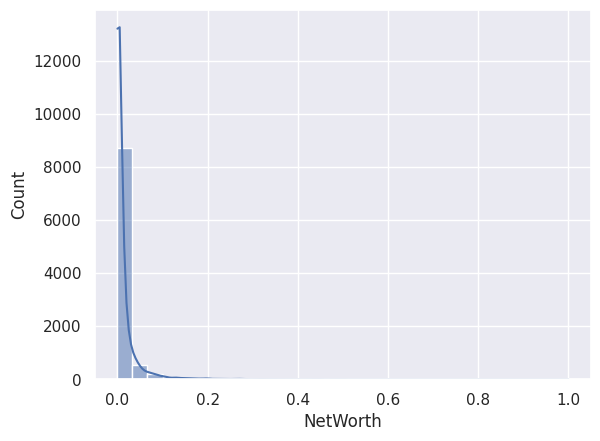

In [4188]:
sns.histplot(df['NetWorth'], bins=30, kde=True)
plt.show()

Видим выброс. Попробуем от него избавиться опять с помощью метода межквартильных расстояний.

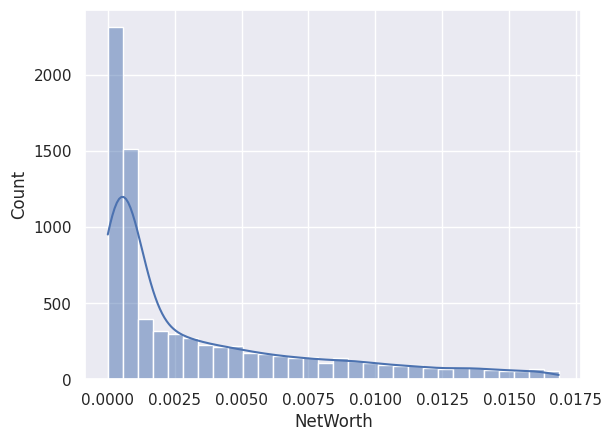

In [4189]:
Q1 = df['NetWorth'].quantile(0.25)
Q3 = df['NetWorth'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q1 + 1.5 * IQR


df['NetWorth'] = df['NetWorth'].where((df['NetWorth'] >= lower_bound) & (df['NetWorth'] <= upper_bound), np.nan)
df.dropna(inplace=True)

sns.histplot(df['NetWorth'], bins=30, kde=True)
plt.show()

После применения метода межквартильных расстояний, выбросов стало меньше. Однако, если не убирать выбросы, финальная модель показывает результат лучше (скорее всего это происходит из-за того, что в данном признаке удалется слишком много строк, и модель недообучается). Остальные признаки смотреть смысла нет, так как они не сильно влияют на таргет, коэффицент их влияния меньше 0.01. Посмотрим на матрицу корреляций признаков.

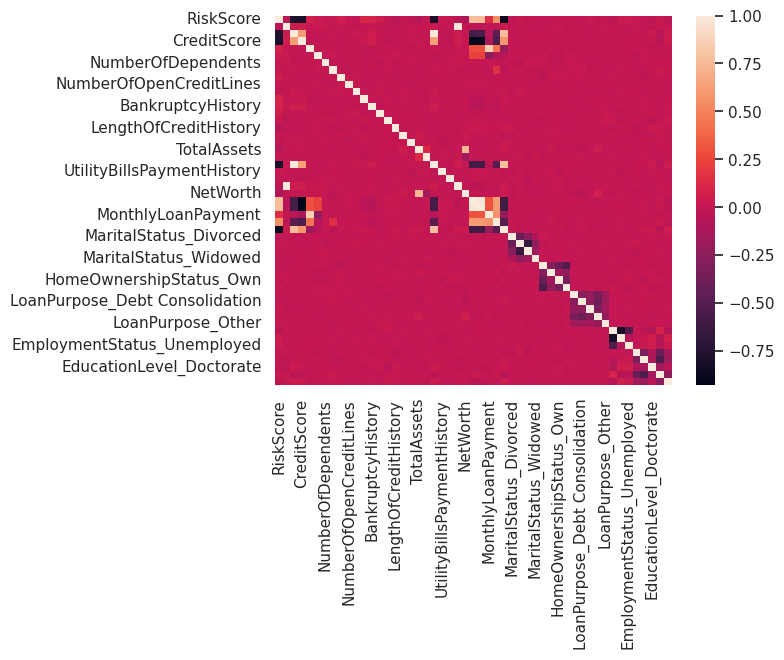

In [4190]:
sns.heatmap(df.drop(['ApplicationDate'], axis=1).corr())
plt.show()

Видим, что самая большая корреляция с тагетом у признаков MonthlyIncome, LoanApproved, AnnualIncome и CreditScore. На CreditScore и LoanApproved уже посмотрели. Теперь посмотрим на признаки MonthlyIncome и AnnualIncome. Судя из названий они скорее всего сильно коррелируют между собой, поэтому один из них можно убрать. Также это видно по матрице корреляций. Важно отметить, что отбор признаков не повлечет за собой улучшение качества модели, даже наоборот. Это скорее нужно для более удобной работы с данными, но так как мы уже близимся к завершению работы с данными, то дальше можно не искать коррелирующие между собой признаки. Если говорить о дальнейшем отборе, то можно убрать какой-то из признаков TotalAssets и NetWorth, так как они сильно коррелируют между собой. Но по вышеописанным причинам смысла в этом нет.

In [4191]:
df.drop(['ApplicationDate'], axis=1).corr()['AnnualIncome']['MonthlyIncome']

np.float64(0.9851576602159083)

In [4192]:
df.drop(['AnnualIncome'], axis=1, inplace=True)

Теперь посмотрим на распределение признака MonthlyIncome.

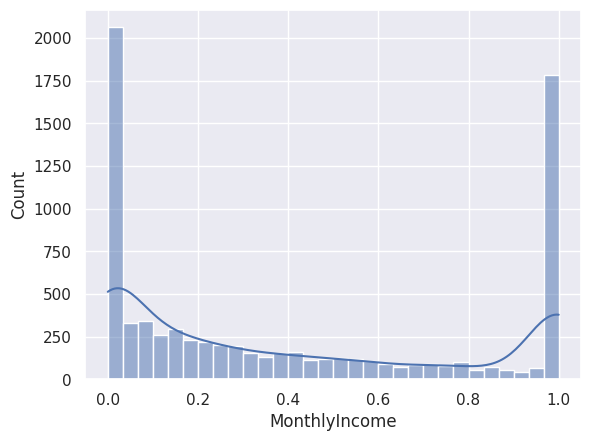

In [4193]:
sns.histplot(df['MonthlyIncome'], bins=30, kde=True)
plt.show()

Опять видим выбросы, попробуем от них избавиться тем же методом, что и в прошлых признаках.

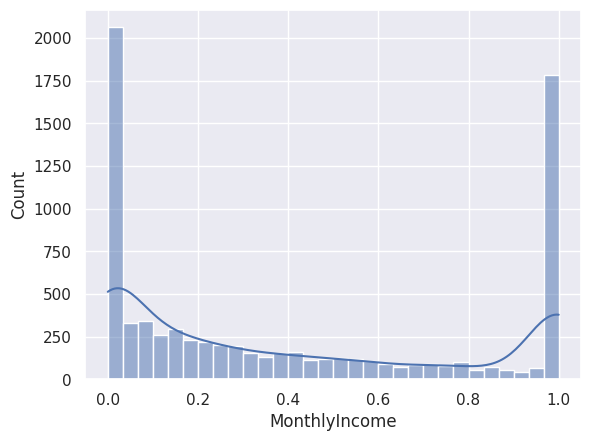

In [4194]:
Q1 = df['MonthlyIncome'].quantile(0.25)
Q3 = df['MonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q1 + 1.5 * IQR


df['MonthlyIncome'] = df['MonthlyIncome'].where((df['MonthlyIncome'] >= lower_bound) & (df['MonthlyIncome'] <= upper_bound), np.nan)
df.dropna(inplace=True)

sns.histplot(df['MonthlyIncome'], bins=30, kde=True)
plt.show()

Как видим ничего не поменялось, так как статистический метод не выявил выбросов. Перейдем к следующему шагу.

### Шаг 2 | Разделение данных

Для лучшего обучения модели будем использовать кросс-валидацию, а именно метод K-fold. С помощью этого метода мы разбиваем датасет на нужное число выборок, среди них выбираем тестовую выборку и тренировочную, и на каждой выборке смотрим метрику. Такой метод позволит нам выбрать наилучшую модель, которую мы можем натренировать. Попробуем разбить датасет на 100 частей.

In [4195]:
from sklearn.model_selection import KFold

X = df.drop(['RiskScore', 'ApplicationDate'], axis=1)

y = df['RiskScore']

kf = KFold(n_splits=100, shuffle=True, random_state=42)


### Шаг 3 | Обучение модели и получение результатов

Для обучения модели попробуем использовать модель Ridge. Она поможет не переобучиться модели, что сделает предсказание более точным а также показывает результат лучше чем обычная модель линейной регрессии LinearRegression.

In [4196]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

models = []
mses = []
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    models.append(model)
    mses.append(mse)

best_model = models[mses.index(min(mses))]
print(min(mses))

11.72500751187226


Получили адекватное значение метрики, значит теперь можем выполнить предсказания на тестовом датасете.

In [4197]:
real_df = pd.read_csv('data/test.csv')

real_df.drop(['AnnualIncome'], axis=1, inplace=True)
for_scale = real_df.drop(['ID', 'ApplicationDate'], axis=1)
for_scale = pd.get_dummies(for_scale, columns=np.array(for_scale.select_dtypes(include=['object']).columns)) # кодирование категориальных данных

for_scale = pd.DataFrame(scaler.fit_transform(for_scale), columns=for_scale.columns) # масштабируем
real_df = real_df.drop(np.array(real_df.columns)[2:], axis=1).join(for_scale)

X_real = real_df.drop(['ID', 'ApplicationDate'], axis=1)

y_real_predict = best_model.predict(X_real)
submission = {'ID': real_df['ID'], 'RiskScore': y_real_predict}
pd.DataFrame(submission).to_csv('submission.csv', index=False)